# Waterhackweek 2020 Project - SnowGW: basin water budget components

Based off of original code by [Emilio Mayorga](https://github.com/emiliom), University of Washington &mdash; [WaterHackWeek 2020](https://waterhackweek.github.io/). See Emilio's original script [mashup_waterbudget.ipynb](https://github.com/waterhackweek/waterdata/blob/master/mashup_waterbudget.ipynb) for helpful information on data sources, packages, and functions.

## Goal

* Construct time series visualizations at daily and/or monthly timescales that show water budget components for basins with snow-groundwater dynamics of interest. (Interim)

## Objective

**Construct and analyze (sub)watershed-scale water budget components for the two example watersheds using geospatial watershed layers and a wide variety of water data, including:**

* HUC8 basin boundaries (and associated HUC10 and HUC12 sub-basins)
* Daymet precipitation and SWE (gridded, daily)
* MODIS SSEBop evapotranspiration (gridded, monthly)
* GRACE water storage anomalies (gridded, monthly)
* USGS NWIS discharge (point, daily)
* USGS groundwater level measurements (point, daily)
* SNOTEL SWE (point, daily)

## Cases
                                                  
**Clackamas, OR**
* HUC-8 Subbasin ID 17090011
* size 2442 km^2
* slope 24.2%
* Total stream length (km) 1810.4 km
* Land cover: evergreen forest (73%), shrub/scrub (10%)

**Upper South Platte, CO**
* HUC-8 Subbasin ID 10190002 
* size: 4,797 km²
* slope: 22.3%
* Total stream length (km) 2812.4 km
* Land cover: evergreen forest (50%), shrub/ scrub: 18%, grassland: 15%

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Setup</b></br>
</div>

## Import packages

In [85]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import contextily as cx
import folium

import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm

from shapely.geometry import box
import pynhd as nhd
import pygeoogc as geoogc
import pygeoutils as geoutils
import hydrodata as hd

## Set the time period

To be reused with every dataset.

In [86]:
date_start = '2015-10-1'
date_end = '2016-09-30'

## Select basin

Select one of the case study basins' HUC8 codes (OR: `10190002`; CO: `10190002`)

We'll use the shorthand "sb" to refer to the "selected basin".

In [87]:
sb_huc08code = '10190002'

# sb_huc08code = '10190002'

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Format basin</b></br>
</div>

### Create HUC10 subwatersheds by first reading HUC12 subwatersheds

Request all HUC12 watersheds whose HUC12 code includes the sb code.

In [88]:
def wfs_getfeatures_cqlfilter(wd, cql_filter=None):
    """
    Use hydrodata packages to issue and process a OpenGeospatial Consortium (OGC) Web Feature Service (WFS) 
    request for WBD watersheds, with an optional filter to obtain only the watersheds we want.
    Returns a nice and clean GeoPandas GeoDataframe in "lat-lon" projection (epsg:4326)
    """
    payload = {
        "service": "wfs",
        "request": "GetFeature",
        "version": wd.version,
        "outputFormat": wd.outformat,
        "typeName": wd.layer,
    }
    if type(cql_filter) is str:
        payload["cql_filter"] = cql_filter

    r = geoogc.RetrySession().get(wd.url, payload)
    
    return geoutils.json2geodf(r.json(), "epsg:4326", crs="epsg:4326")

In [89]:
sb_wdhuc12 = nhd.WaterData('huc12', crs='epsg:4269')

In [90]:
print(sb_wdhuc12.get_validnames())

['huc12', 'tohuc', 'areaacres', 'areasqkm', 'name', 'hutype', 'humod', 'states', 'noncontrib', 'bbox']


In [91]:
# HUC filter (cql_filter) will be the string "huc12 LIKE '17030001%'"
sb_huc12_gdf = wfs_getfeatures_cqlfilter(
    sb_wdhuc12, 
    cql_filter=f"huc12 LIKE '{sb_huc08code}%'"
)

sb_huc12_gdf.head(2)

,geometry,huc12,tohuc,areaacres,areasqkm,name,hutype,humod,states,noncontrib,bbox
0,"MULTIPOLYGON (((-105.28870 39.71850, -105.2821...",101900020806,101900020808,17733.37049,71.764404,Mount Vernon Creek-Bear Creek,S,NM,CO,0,"[-105.3294, 39.6276, -105.1827, 39.7194]"
1,"MULTIPOLYGON (((-104.99960 39.43420, -105.0001...",101900020607,101900020608,10832.31800,43.836836,Indian Creek,S,NM,CO,0,"[-105.0962, 39.3574, -104.9948, 39.4729]"


Create `huc10` column from `huc12` codes.

In [92]:
sb_huc12_gdf['huc10'] = sb_huc12_gdf.huc12.str[:-2]
cols = ['huc10', 'areasqkm', 'geometry']
sb_huc10_gdf = sb_huc12_gdf[cols].dissolve(by='huc10', aggfunc='sum', as_index=False)

len(sb_huc10_gdf)

9

In [93]:
sb_huc10_gdf.head(2)

,huc10,geometry,areasqkm
0,1019000201,"POLYGON ((-105.12420 38.90850, -105.12590 38.9...",549.227554
1,1019000202,"POLYGON ((-105.42905 39.38350, -105.42900 39.3...",603.347915


Use the `total_bounds` GeoDataFrame function to extract the outer bounding box coordinates, then create a simple GeoSeries out of that rectangle for reuse later on.

In [94]:
sb_huc10_gdf.total_bounds

array([-105.8681,   38.8932, -104.8089,   39.764 ])

In [95]:
sb_bbox = gpd.GeoSeries(box(*sb_huc10_gdf.total_bounds), crs=sb_huc10_gdf.crs)

Set `xarray` spatial (lat & lon) "slices" here, for reuse below when doing lat-lon region clipping (via the `.sel` method) of `xarray` datasets.

In [96]:
sb_lon_slice = slice(sb_bbox.bounds.minx[0], sb_bbox.bounds.maxx[0])
sb_lat_slice = slice(sb_bbox.bounds.miny[0], sb_bbox.bounds.maxy[0])

Plot HUC8 basin + HUC10 sub-basins

In [97]:
# Note: There are other basemap tiles besides StamenTerrain
m = folium.Map(tiles='StamenTerrain', attr='ESRI')

In [98]:
# Bounding box
folium.GeoJson(
    sb_bbox.geometry,
    style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
).add_to(m)

# Set the map extent (bounds) to the extent of the bounding box
m.fit_bounds(m.get_bounds())

# HUC10 sub-watershed polygons
for i, i_gdf in sb_huc10_gdf.iterrows():
    folium.GeoJson(
        i_gdf.geometry,
        style_function=lambda feature: {'color': 'black', 'fillOpacity': 0.0},
        tooltip=i_gdf['huc10']
    ).add_child(
        folium.Popup(f"<b>HUC10:</b><br> {i_gdf['huc10']}<br><b>watershed area:</b><br> {i_gdf['areasqkm']:.0f} km^2")
    ).add_to(m)

In [99]:
m

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Read data, and extract over selection (time and basin) </b></br>
</div>

## Precipitation and SWE from DayMet

### Get metadata ("lazy loading")

In [100]:
daymet_opendap_url = "https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml"
    
daymet_ds = xr.open_dataset(daymet_opendap_url)

### Get the selected basin bounding box in the DayMet projection coordinates

In [101]:
daymet_ds_grid_mapping_name = 'lambert_conformal_conic'

In [102]:
# DayMet crs information is in: ds.lambert_conformal_conic ('lcc')
lcc_crs = CRS.from_cf(daymet_ds[daymet_ds_grid_mapping_name].attrs)

In [103]:
# Reproject our bounding box polygon into this new coordinate system, to use in our request
sb_bbox_lcc = sb_bbox.to_crs(lcc_crs)

In [104]:
sb_lcc_bnd = sb_bbox_lcc.bounds

### Get the DayMet data for the selected XYT "cube"

In [105]:
sb_daymet_da = daymet_ds.sel(
    time=slice(date_start, date_end),
    x=slice(sb_lcc_bnd.minx[0], sb_lcc_bnd.maxx[0]),
    y=slice(sb_lcc_bnd.maxy[0], sb_lcc_bnd.miny[0]) # note the reversed y values!
)

In [106]:
sb_daymet_da

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 366, x: 93, y: 97)
Coordinates:
  * x                        (x) float32 -486250.0 -485250.0 ... -394250.0
  * y                        (y) float32 -274000.0 -275000.0 ... -370000.0
  * time                     (time) datetime64[ns] 2015-10-01 ... 2016-09-30
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

Select precipitation and SWE

In [107]:
sb_daymet_da_prcp = sb_daymet_da.prcp
sb_daymet_da_swe = sb_daymet_da.swe

In [108]:
sb_daymet_da_prcp

<xarray.DataArray 'prcp' (time: 366, y: 97, x: 93)>
[3301686 values with dtype=float32]
Coordinates:
  * x        (x) float32 -486250.0 -485250.0 -484250.0 ... -395250.0 -394250.0
  * y        (y) float32 -274000.0 -275000.0 -276000.0 ... -369000.0 -370000.0
  * time     (time) datetime64[ns] 2015-10-01 2015-10-02 ... 2016-09-30
    lat      (y, x) float32 39.750988 39.75166 39.75233 ... 38.903164 38.9037
    lon      (y, x) float32 -105.944016 -105.93183 ... -104.76736 -104.75532
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

In [109]:
sb_daymet_da_swe

<xarray.DataArray 'swe' (time: 366, y: 97, x: 93)>
[3301686 values with dtype=float32]
Coordinates:
  * x        (x) float32 -486250.0 -485250.0 -484250.0 ... -395250.0 -394250.0
  * y        (y) float32 -274000.0 -275000.0 -276000.0 ... -369000.0 -370000.0
  * time     (time) datetime64[ns] 2015-10-01 2015-10-02 ... 2016-09-30
    lat      (y, x) float32 39.750988 39.75166 39.75233 ... 38.903164 38.9037
    lon      (y, x) float32 -105.944016 -105.93183 ... -104.76736 -104.75532
Attributes:
    long_name:     snow water equivalent
    units:         kg/m2
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: mean

### Reproject to lat-lon (to use with other data)

In [110]:
def reproject_da_as_ds(da, from_grid_mapping_name, from_crs, to_crs):
    """
    Reproject an xarray DataArray using rioxarray and the expectation of CF convention 
    for projection information.
    This function is fairly generic and can be reused with other datasets with only small changes.
    Returns an xarray DataSet with the expected, CF-convention projection information.
    """
    ds = da.to_dataset()
    # Use rioxarray to improve (clean up) the CRS metadata, 
    # so it can be used in the reprojection step
    ds.rio.write_crs(from_crs.to_string(), inplace=True)
    
    # Reproject the xarray dataset
    # Note: the drop_vars step could be done outside this function, since it's source-data cleanup
    reproj_ds = (
        ds
        .drop_vars(['lon', 'lat'])
        .rio.reproject(to_crs)
    )
    
    # Clean up the projection information and coordinates of the reprojected dataset
    to_grid_mapping_name = reproj_ds[from_grid_mapping_name].attrs['grid_mapping_name']
    reproj_ds = (
        reproj_ds
        .rio.set_spatial_dims('x', 'y')
        .rio.write_crs(to_crs)
        .rename({"x": "lon", "y": "lat", from_grid_mapping_name: to_grid_mapping_name}) 
        # this last step applies only when reprojecting to lat-lon
    )
    reproj_ds.attrs['grid_mapping'] = to_grid_mapping_name
    reproj_ds[da.name].attrs['grid_mapping'] = to_grid_mapping_name
    
    return reproj_ds

In [111]:
sb_daymet_ds_prcp = reproject_da_as_ds(sb_daymet_da_prcp, daymet_ds_grid_mapping_name, lcc_crs, "epsg:4326")
sb_daymet_ds_swe = reproject_da_as_ds(sb_daymet_da_swe, daymet_ds_grid_mapping_name, lcc_crs, "epsg:4326")

Quick check on the resulting cell sizes, in degrees

In [112]:
def print_cellsizes(dimcoord):
    print(dimcoord.values[1] - dimcoord.values[0], dimcoord.values[-1] - dimcoord.values[-2])

In [113]:
print_cellsizes(sb_daymet_ds_prcp.lon)
print_cellsizes(sb_daymet_ds_swe.lon)

0.010979028709044769 0.010979028709044769
0.010979028709044769 0.010979028709044769


In [114]:
print_cellsizes(sb_daymet_ds_prcp.lat)
print_cellsizes(sb_daymet_ds_swe.lat)

-0.010979028709037664 -0.010979028709044769
-0.010979028709037664 -0.010979028709044769


Clip to basin polygon boundary

In [115]:
sb_daymet_ds_prcp = sb_daymet_ds_prcp.rio.clip(sb_huc10_gdf.geometry, all_touched=True)
sb_daymet_ds_swe = sb_daymet_ds_swe.rio.clip(sb_huc10_gdf.geometry, all_touched=True)

Look ("5th time step from the end")

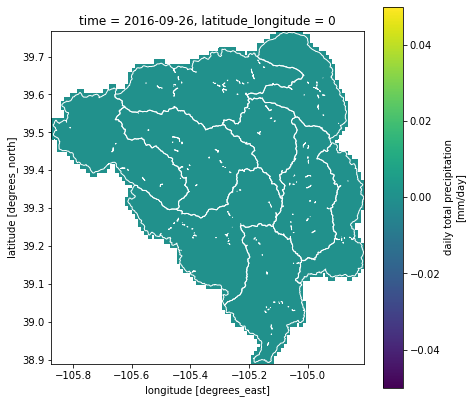

In [116]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_daymet_ds_prcp.prcp.isel(time=-5).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

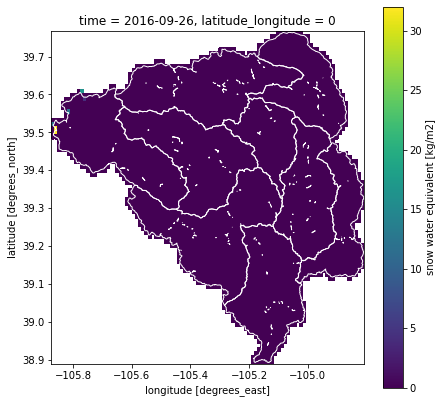

In [117]:
f, ax = plt.subplots(1, figsize=(7, 7))
sb_daymet_ds_swe.swe.isel(time=-5).plot(ax=ax)
sb_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

## ETa from MODIS SSEBop

From Emilio's code

## TWS anomalies from GRACE

From Emilio's code

## Discharge from USGS NWIS

From Emilio's code

## Groundwater level from USGS

Import directly from separately downloaded data...?

## SWE from SNOTEL

Import directly from separately downloaded data...?